# Exploratory statistical analysis

## Preparation

Load the data

In [1]:
from cesnet_datazoo.datasets import CESNET_QUIC22
from cesnet_datazoo.config import DatasetConfig

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
    return_other_fields=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()

data_df.columns

Index(['ID', 'SRC_IP', 'DST_IP', 'DST_ASN', 'SRC_PORT', 'DST_PORT', 'PROTOCOL',
       'QUIC_VERSION', 'QUIC_SNI', 'QUIC_USERAGENT', 'TIME_FIRST', 'TIME_LAST',
       'PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Add necessary imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Add APP_NAME column, which is transformed from the APP column.

In [3]:
data_df["APP_NAME"] = data_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

Add CATEGORY column, which is transformed from the APP column and categories mapping dictionary.

In [4]:
categories_enum = {category: i for i, category in dataset._tables_cat_enum.items()}
app_to_categories = dataset.class_info.categories_mapping
app_enum = {i: app for i, app in dataset._tables_app_enum.items()}
app_to_categories.update({
    "bongacams": "Streaming media",
    "gothbb": "E-commerce",
    "vkontakte": "Social",
    "poe-ninja": "Games",
    "unpkg": "Streaming media",
    "easylist": "Other services and APIs",
    "default-background": "default",
    "uber": "Other services and APIs",
})

data_df["CATEGORY"] = data_df["APP"].apply(lambda x: app_to_categories[app_enum[x]])

Declare a function for properly saving the plots

In [5]:
import os

ARE_PICTURES_SAVED = False

# plt.rcParams.update({'font.size': 26})

def save_fig_to_images_dir(fig, fig_name, images_dir=("images", "statistical_analysis")):
    try:
        os.makedirs(images_dir)
    except FileExistsError:
        pass
    
    try:
        fig.savefig(os.path.join(*images_dir, fig_name), dpi=300, bbox_inches='tight',
                    format='pdf', transparent=True, pad_inches=0.1)
        print(f"Figure {fig_name} saved successfully.")
    except Exception as e:
        print(f"Error saving figure {fig_name}: {e}")

## Overview

Explore columns of the dataset

In [6]:
data_df.columns

Index(['ID', 'SRC_IP', 'DST_IP', 'DST_ASN', 'SRC_PORT', 'DST_PORT', 'PROTOCOL',
       'QUIC_VERSION', 'QUIC_SNI', 'QUIC_USERAGENT', 'TIME_FIRST', 'TIME_LAST',
       'PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP',
       'APP_NAME', 'CATEGORY'],
      dtype='object')

Choose the columns to be used for the analysis.

In [7]:
columns = ["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION"]

Describe the feature columns

In [8]:
data_df[columns].describe(percentiles=[0.25, 0.5, 0.75, 0.99])

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.000000
mean,44.652401,150.649124,1.639926e+04,1.692565e+05,9.468164,23.137939,4.55137,3.253521
std,626.005371,2088.689941,6.881355e+05,2.636015e+06,29.605572,7.269448,1.87504,12.313560
min,1.000000,1.000000,1.228000e+03,5.900000e+01,0.000175,2.000000,0.00000,0.000000
25%,8.000000,9.000000,2.730000e+03,3.244000e+03,0.094604,17.000000,3.00000,0.078000
50%,12.000000,13.000000,4.178500e+03,5.257000e+03,0.218190,25.000000,4.00000,0.156000
75%,22.000000,24.000000,7.168000e+03,1.051200e+04,4.976531,30.000000,6.00000,0.576000
99%,541.000000,2628.030000,1.332815e+05,3.132121e+06,135.988821,30.000000,10.00000,51.949011
max,162848.000000,489305.000000,2.060549e+08,6.242670e+08,356.115967,30.000000,15.00000,291.115997


Build a bar plot, which shows the number of flows per direction.

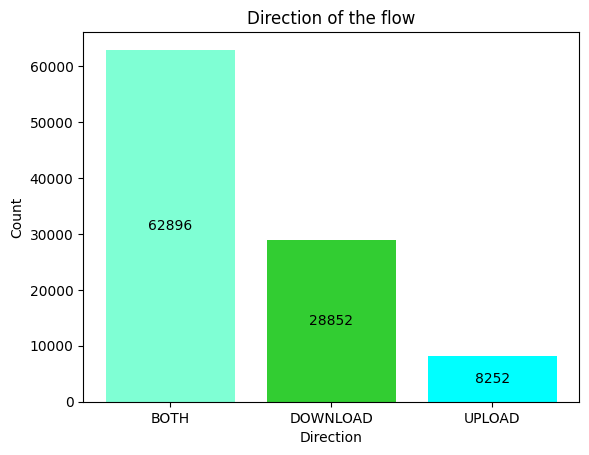

In [9]:
DIRECTION_COEFFICIENT = 0.5

# create a new column to indicate the direction of the flow, default is BOTH
data_df[["DIRECTION"]] = "BOTH"

# set the direction of the flow based on the number of bytes
data_df.loc[data_df["BYTES"] * DIRECTION_COEFFICIENT > data_df["BYTES_REV"], "DIRECTION"] = "UPLOAD"
data_df.loc[data_df["BYTES"] < data_df["BYTES_REV"] * DIRECTION_COEFFICIENT, "DIRECTION"] = "DOWNLOAD"

direction_counts = data_df["DIRECTION"].value_counts()

fig = plt.figure()
ax = fig.add_subplot()
bar_plot = ax.bar(direction_counts.index, direction_counts.values, color=["aquamarine", "limegreen", "cyan"])
ax.bar_label(bar_plot, label_type="center")
ax.set_title("Direction of the flow")
ax.set_xlabel("Direction")
ax.set_ylabel("Count")

if ARE_PICTURES_SAVED: save_fig_to_images_dir(fig, "direction_of_the_flow.pdf")

Examine most popular apps

In [10]:
data_df["APP_NAME"].value_counts()

APP_NAME
bongacams                6830
cloudflare-cdnjs         6355
alza-identity            6323
flightradar24            6110
playradio                5551
                         ... 
google-authentication       9
instagram                   9
ebay-kleinanzeigen          9
google-autofill             8
uber                        7
Name: count, Length: 101, dtype: int64

Build a bar plot to visualize the distribution of flow categories with more than 200 occurrences.

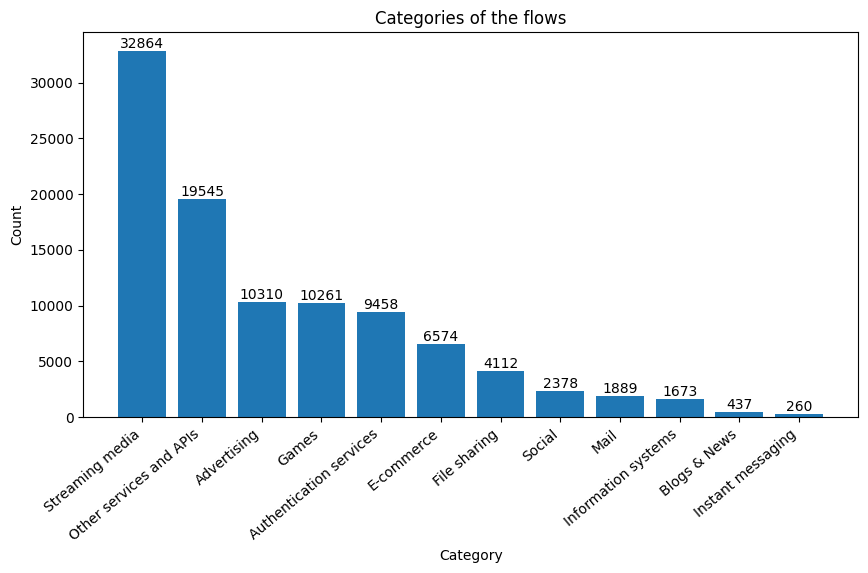

In [11]:
category_counts = data_df["CATEGORY"].value_counts()
category_counts = category_counts[category_counts > 200]

fig = plt.figure()
ax = fig.add_subplot()
bar_plot = ax.bar(category_counts.index, category_counts.values)
ax.bar_label(bar_plot)
ax.set_title("Categories of the flows")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
ax.set_xticks(np.arange(len(category_counts.index)))
# set the x-ticks to be the category names
ax.set_xticklabels(category_counts.index, rotation=40, ha="right")
# make graph wider
fig.set_size_inches(10, 5)

if ARE_PICTURES_SAVED: save_fig_to_images_dir(fig, "categories_of_the_flows.pdf")

Build a pie chart of the most popular apps, apps with less than 1000 packets are grouped into 'Other' category

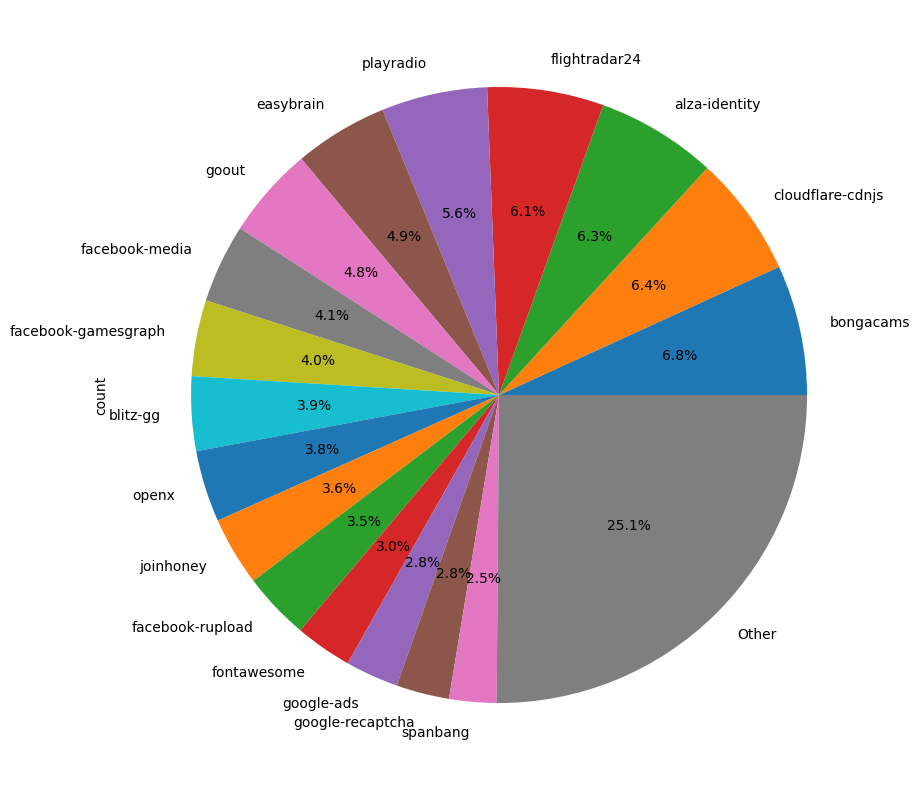

In [12]:
APP_COUNTS_THRESHOLD = 2000

app_counts = data_df["APP_NAME"].value_counts()
app_counts = app_counts[app_counts > APP_COUNTS_THRESHOLD]
app_counts["Other"] = data_df["APP_NAME"].value_counts()[data_df["APP_NAME"].value_counts() <= APP_COUNTS_THRESHOLD].sum()

fig = plt.figure()
ax = fig.add_subplot()
app_counts.plot.pie(y="PACKETS", legend=None, ax=ax, figsize=(10, 10), autopct='%1.1f%%')
if ARE_PICTURES_SAVED: save_fig_to_images_dir(fig, "apps_of_the_flows.pdf")

## Concrete apps

In [13]:
# streaming media
facebookmedia_describe = data_df[columns][data_df["APP_NAME"] == "facebook-media"].describe(percentiles=[0.05, 0.5, 0.75, 0.90, 0.95]).round(2)

# print(
facebookmedia_describe
# .to_latex(escape=True, float_format="%.2f")
# )

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,4135.00,4135.00,4135.00,4135.0,4135.00,4135.00,4135.00,4135.00
mean,173.14,1186.96,19952.48,1456258.5,12.56,26.37,3.97,1.36
std,630.15,4245.49,60105.91,5276597.0,34.07,5.89,1.43,7.07
min,1.00,1.00,1228.00,75.0,0.00,2.00,1.00,0.00
5%,5.00,8.00,1839.70,3184.5,0.02,14.00,2.00,0.01
50%,19.00,48.00,5383.00,45796.0,0.46,30.00,4.00,0.05
75%,104.00,520.50,14649.50,599080.5,11.63,30.00,5.00,0.18
90%,409.60,2906.60,45365.80,3544803.0,34.46,30.00,6.00,1.11
95%,813.20,6161.20,82862.80,7636199.0,51.83,30.00,7.00,6.36
max,25729.00,103356.00,2489223.00,127285712.0,318.36,30.00,11.00,161.35


In [14]:
# advertising
openx_describe = data_df[columns][data_df["APP_NAME"] == "openx"].describe(percentiles=[0.05, 0.5, 0.75, 0.95]).round(2)

# print(
openx_describe
# .to_latex(escape=True, float_format="%.2f")
# )

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,3760.00,3760.00,3760.00,3760.00,3760.00,3760.00,3760.00,3760.00
mean,29.90,59.54,9097.69,61713.43,9.91,22.18,5.05,3.65
std,78.33,443.10,43072.16,606455.44,22.62,7.59,2.27,10.51
min,1.00,1.00,1228.00,348.00,0.01,2.00,1.00,0.00
5%,5.00,5.00,1818.00,2414.00,0.07,10.00,2.00,0.05
50%,12.00,10.00,4689.50,4540.50,0.53,23.00,5.00,0.31
75%,27.00,24.00,8679.25,7610.75,8.01,30.00,7.00,1.69
95%,100.00,172.05,28989.35,170342.30,53.87,30.00,9.00,23.55
max,2020.00,14877.00,2561158.00,21810628.00,305.07,30.00,12.00,170.39


In [15]:
# games
easybrain_describe = data_df[columns][data_df["APP_NAME"] == "easybrain"].describe(percentiles=[0.05, 0.5, 0.75, 0.9, 0.95]).round(2)

# print(
easybrain_describe
# .to_latex(escape=True, float_format="%.2f")
# )

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,4924.00,4924.00,4924.00,4924.00,4924.00,4924.00,4924.00,4924.00
mean,19.50,43.18,3811.88,42155.79,4.38,20.00,3.72,2.55
std,145.71,498.89,10475.12,610825.56,12.27,6.08,1.51,7.72
min,1.00,2.00,1228.00,1910.00,0.02,4.00,1.00,0.02
5%,4.00,7.00,1886.15,2963.00,0.06,11.00,2.00,0.05
50%,8.00,9.00,2532.00,3206.00,0.09,17.00,3.00,0.09
75%,12.00,13.00,3389.25,4042.00,0.31,25.00,4.00,0.14
90%,26.00,33.00,4870.90,21636.80,16.13,30.00,6.00,7.99
95%,58.00,101.70,7232.50,101176.55,27.99,30.00,7.00,20.04
max,9447.00,22663.00,617954.00,27725098.00,150.30,30.00,11.00,90.15


## Concrete app categories

In [16]:
# print(
data_df[columns][data_df["CATEGORY"] == "Streaming media"].describe(percentiles=[0.05, 0.5, 0.75, 0.95]).round(2)
# .to_latex(escape=True, float_format="%.2f")
# )

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,32864.00,32864.00,32864.00,3.286400e+04,32864.00,32864.00,32864.00,32864.00
mean,47.39,211.96,9668.01,2.466978e+05,8.32,23.50,4.54,2.57
std,455.75,3171.17,47840.43,4.022233e+06,25.45,6.61,1.75,7.20
min,1.00,1.00,1228.00,7.500000e+01,0.00,2.00,0.00,0.00
5%,5.00,5.00,1686.00,2.392000e+03,0.04,11.00,2.00,0.03
50%,12.00,13.00,3997.50,4.544000e+03,0.18,25.00,4.00,0.15
75%,21.00,24.00,6972.25,1.046900e+04,5.08,30.00,6.00,0.49
95%,141.00,456.00,28802.85,4.736682e+05,40.07,30.00,8.00,17.85
max,68950.00,489305.00,4700575.00,6.242670e+08,321.50,30.00,12.00,180.55


In [17]:
# print(
data_df[columns][data_df["CATEGORY"] == "Advertising"].describe(percentiles=[0.05, 0.5, 0.75, 0.95]).round(2)
# .to_latex(escape=True, float_format="%.2f")
# )

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,10310.00,10310.00,10310.00,10310.00,10310.00,10310.00,10310.00,10310.00
mean,30.92,80.60,10154.26,83085.90,9.18,21.52,5.04,3.70
std,115.35,686.26,38071.96,832801.06,22.25,7.15,2.03,9.66
min,1.00,1.00,1228.00,348.00,0.00,2.00,1.00,0.00
5%,5.00,6.00,2176.00,2210.45,0.06,11.00,2.00,0.05
50%,11.00,10.00,4574.00,4007.50,0.27,20.00,5.00,0.22
75%,21.00,20.00,7894.00,6996.00,6.64,30.00,6.00,1.22
95%,98.00,150.00,29858.60,138106.75,48.83,30.00,9.00,24.99
max,4994.00,35005.00,2561158.00,42672104.00,340.98,30.00,13.00,170.39


In [18]:
# print(
data_df[columns][data_df["CATEGORY"] == "Games"].describe(percentiles=[0.05, 0.5, 0.75, 0.95]).round(2)
# .to_latex(escape=True, float_format="%.2f")
# )

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,10261.00,10261.00,1.026100e+04,10261.00,10261.00,10261.00,10261.00,10261.00
mean,63.51,59.06,5.683323e+04,55672.07,3.98,19.66,3.66,2.01
std,1696.87,527.43,2.142102e+06,611714.81,11.06,7.62,1.62,6.49
min,1.00,2.00,1.228000e+03,1588.00,0.02,4.00,0.00,0.00
5%,4.00,4.00,1.610000e+03,2353.00,0.04,9.00,2.00,0.04
50%,8.00,9.00,2.591000e+03,3426.00,0.10,17.00,3.00,0.09
75%,15.00,17.00,3.899000e+03,8058.00,0.70,30.00,4.00,0.22
95%,77.00,192.00,9.321000e+03,203995.00,25.71,30.00,7.00,15.07
max,162848.00,22663.00,2.060549e+08,27725098.00,175.16,30.00,11.00,90.15


## Graph generation

/tmp/ipykernel_93600/188687003.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))


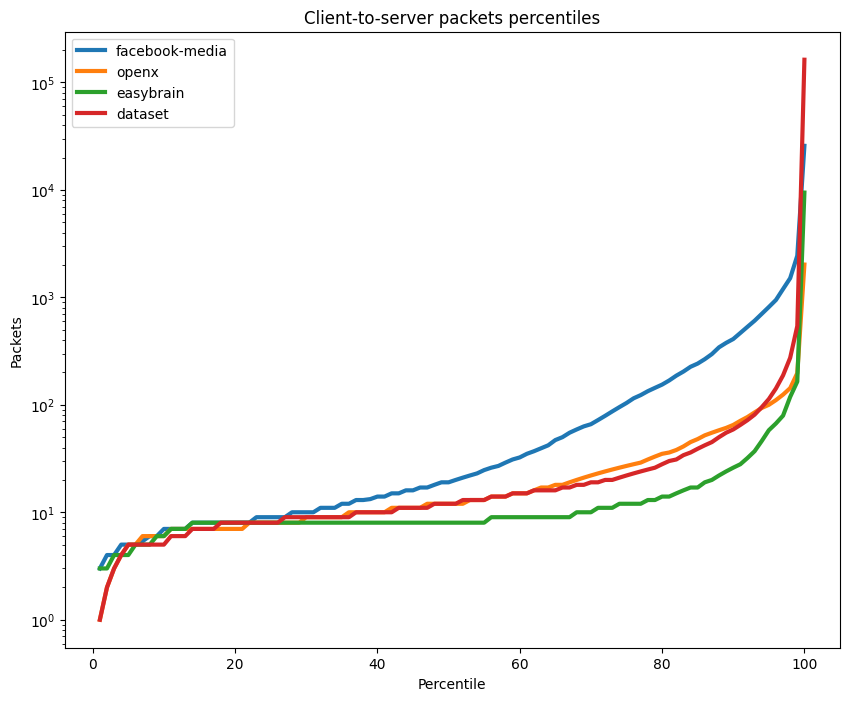

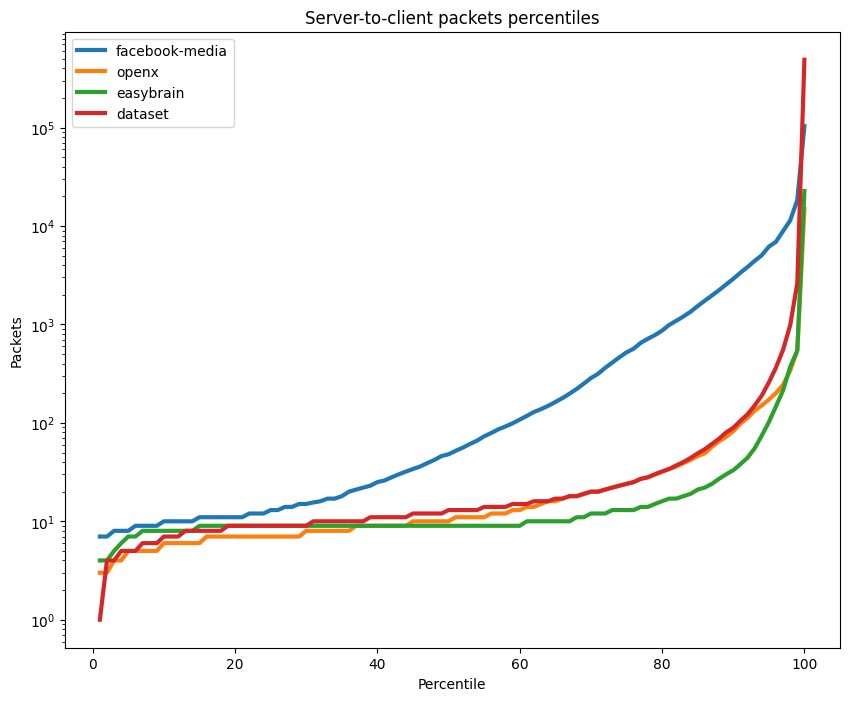

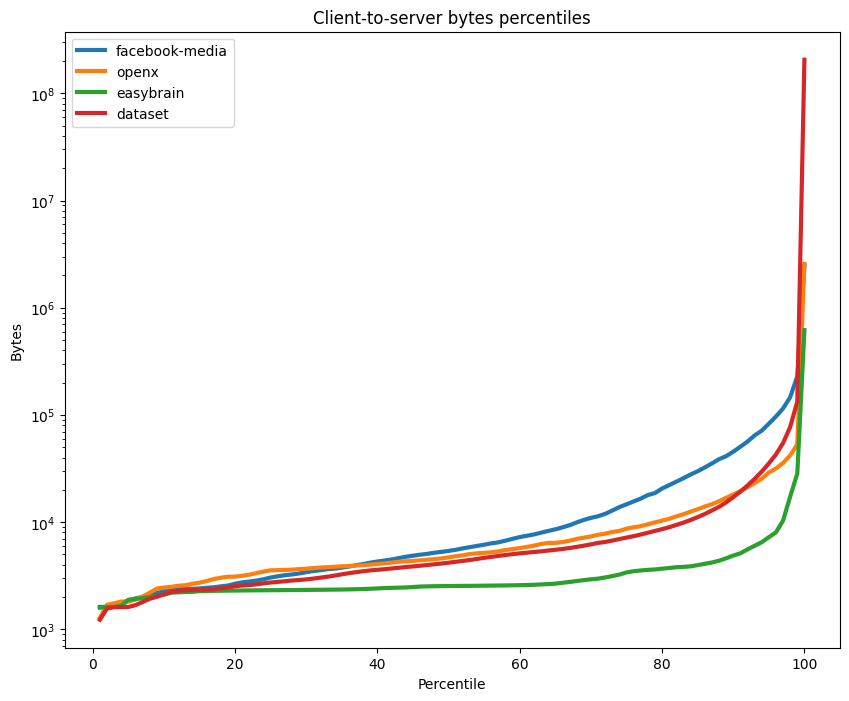

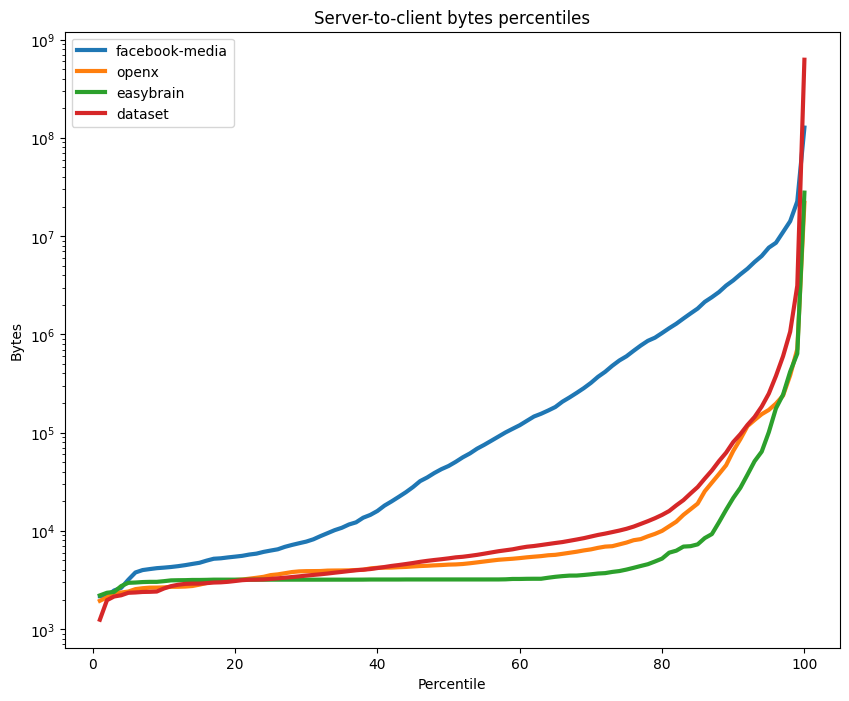

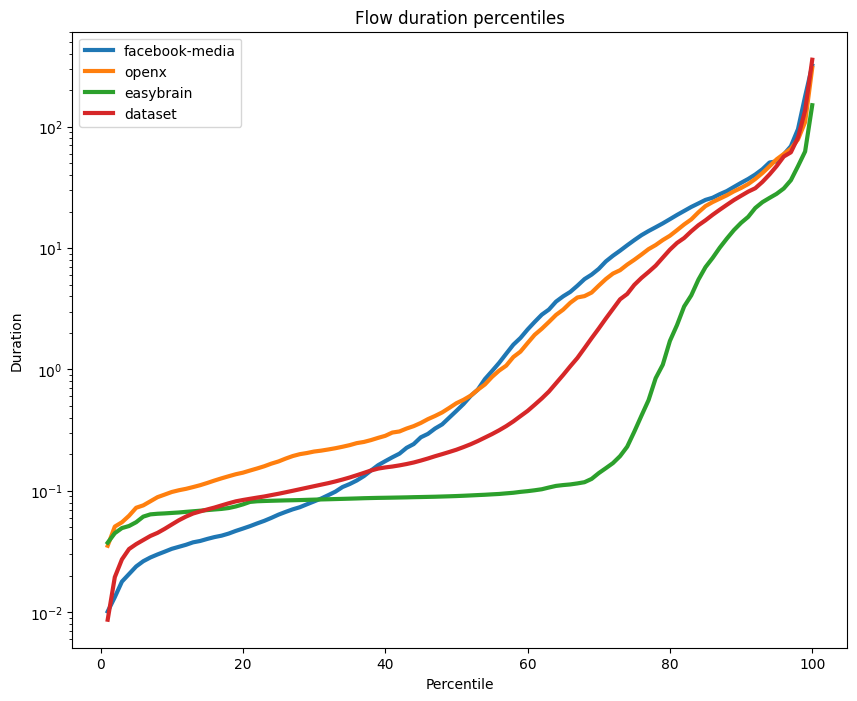

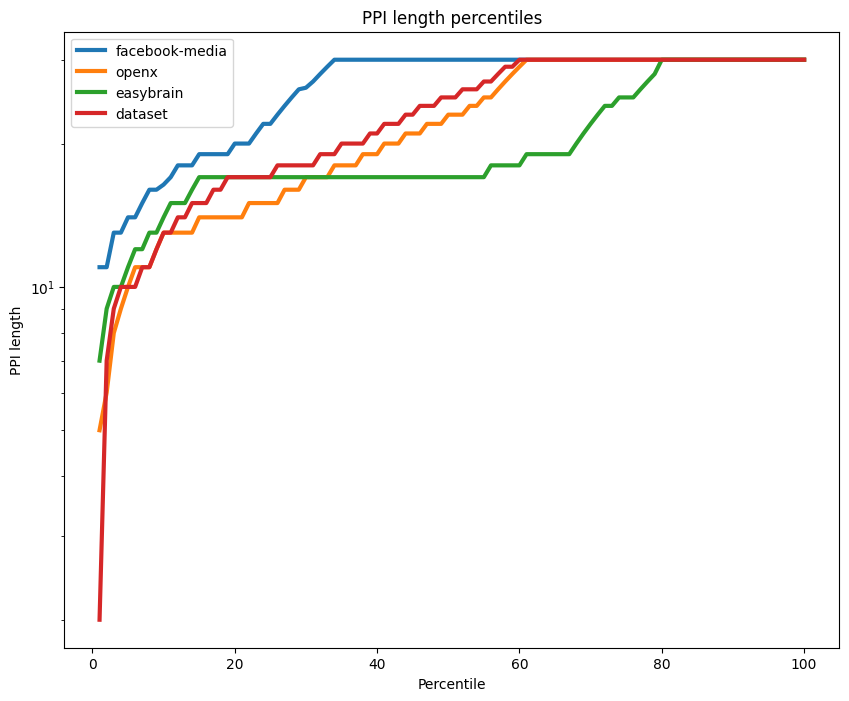

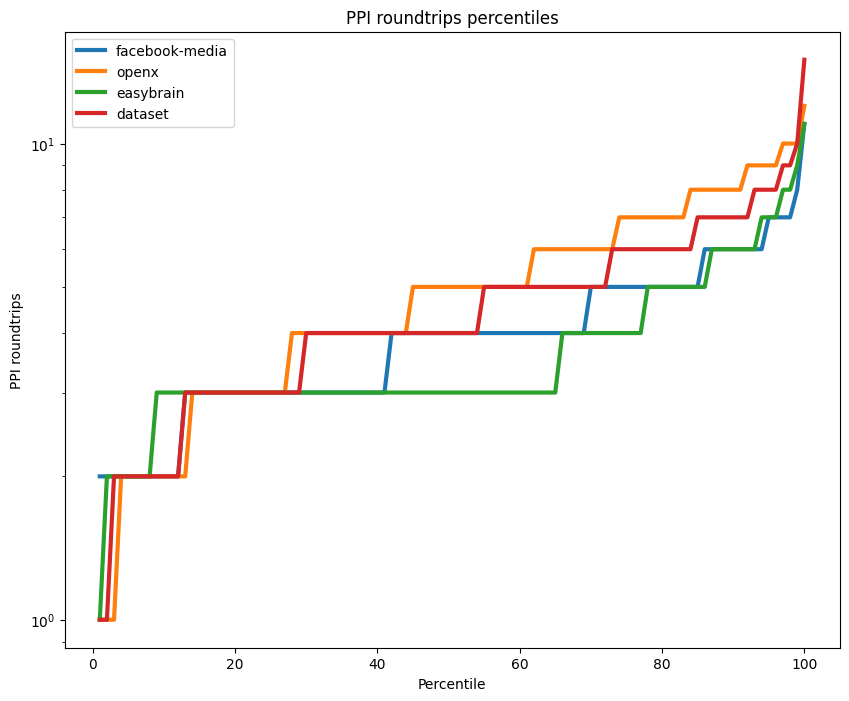

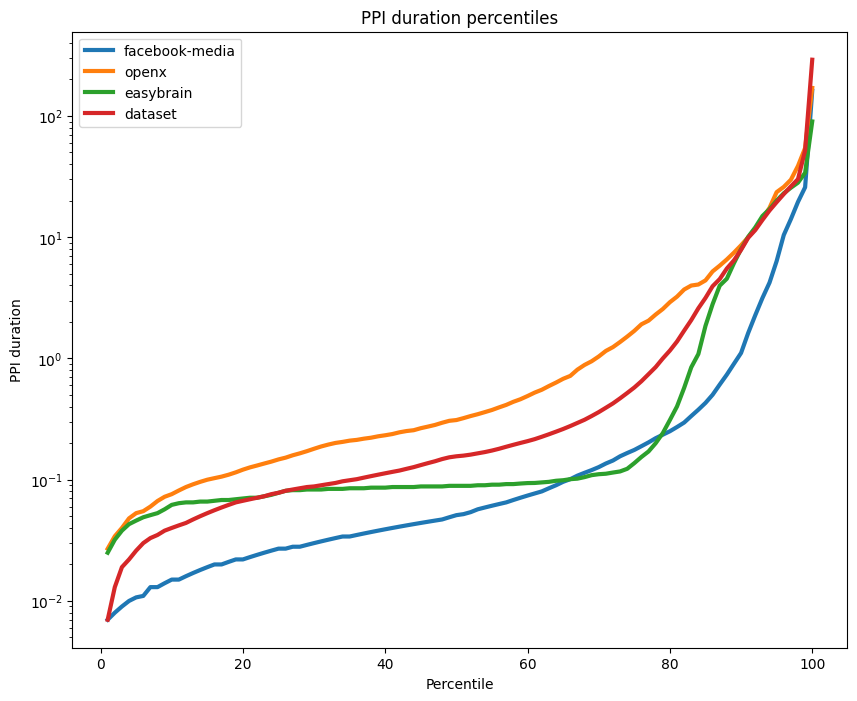

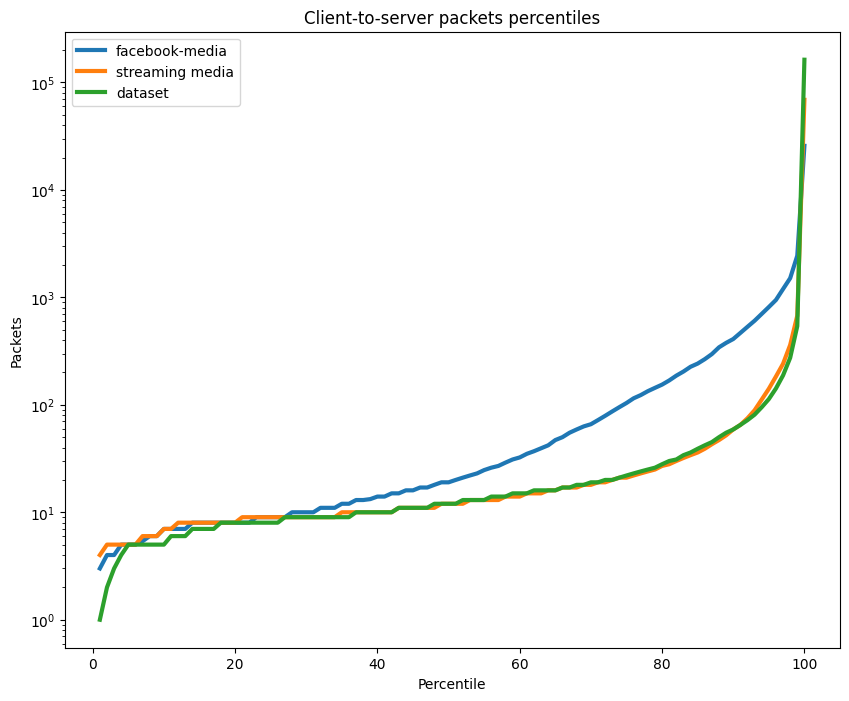

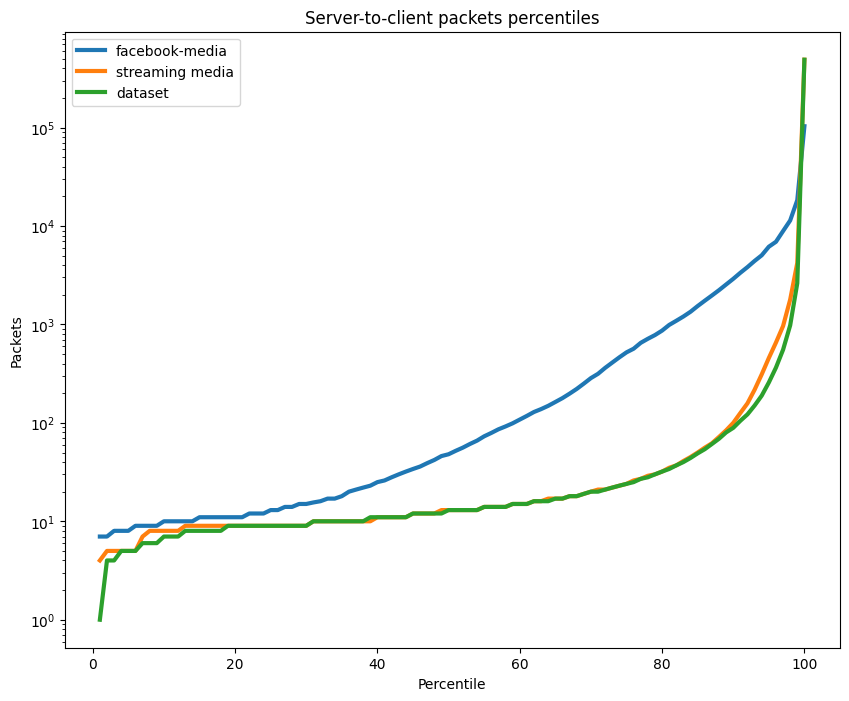

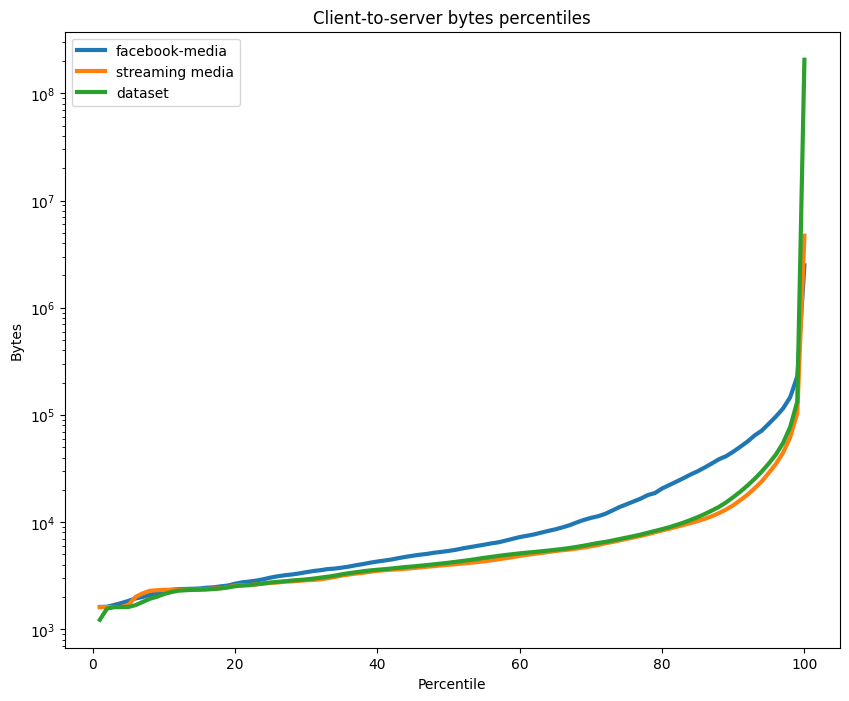

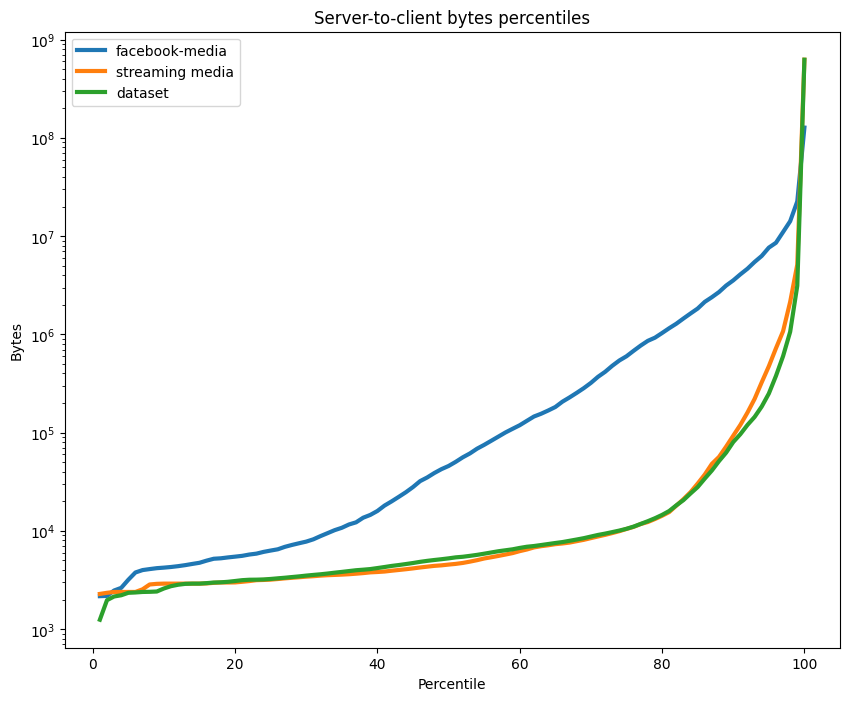

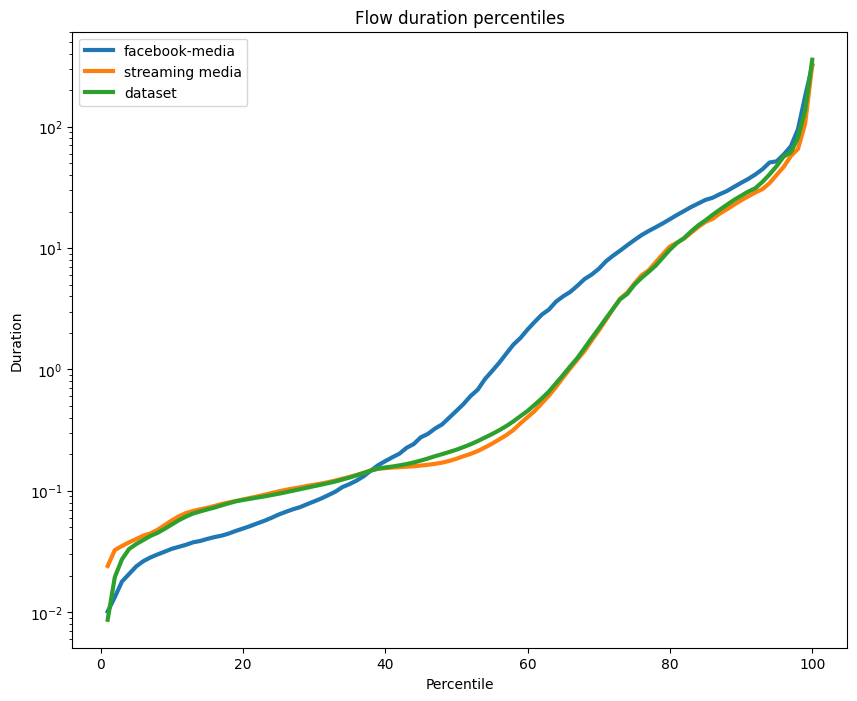

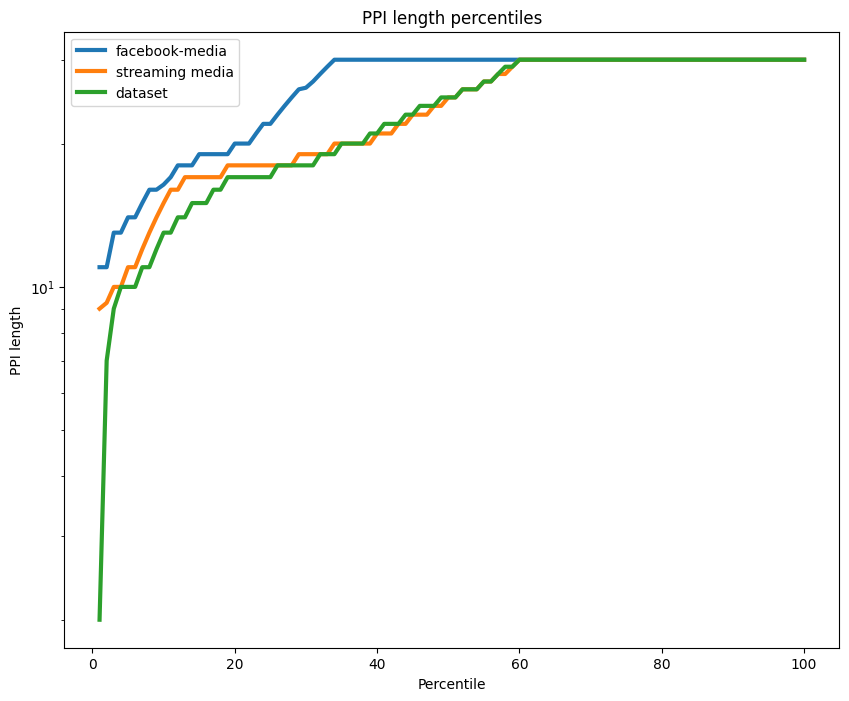

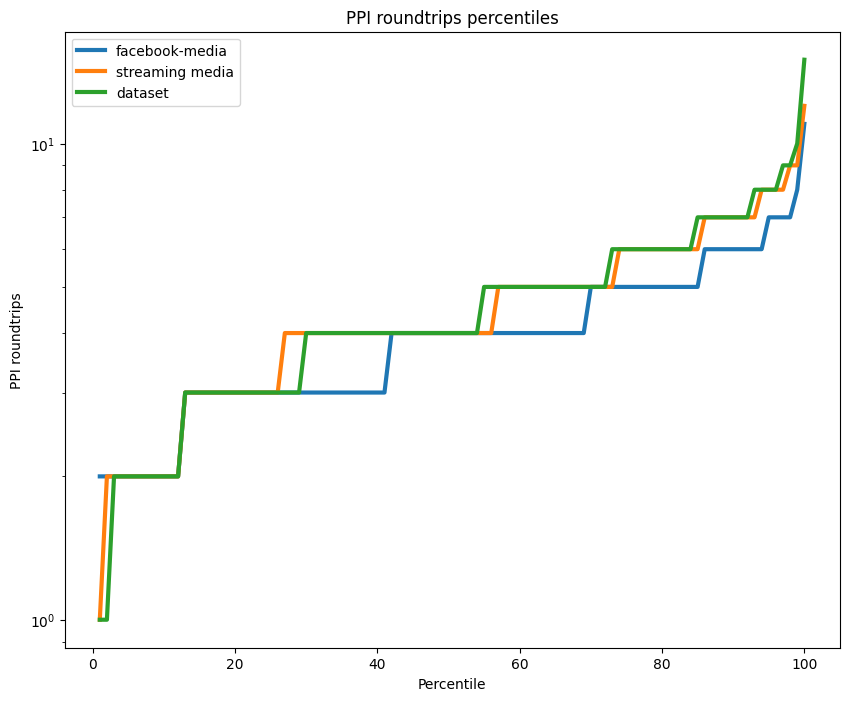

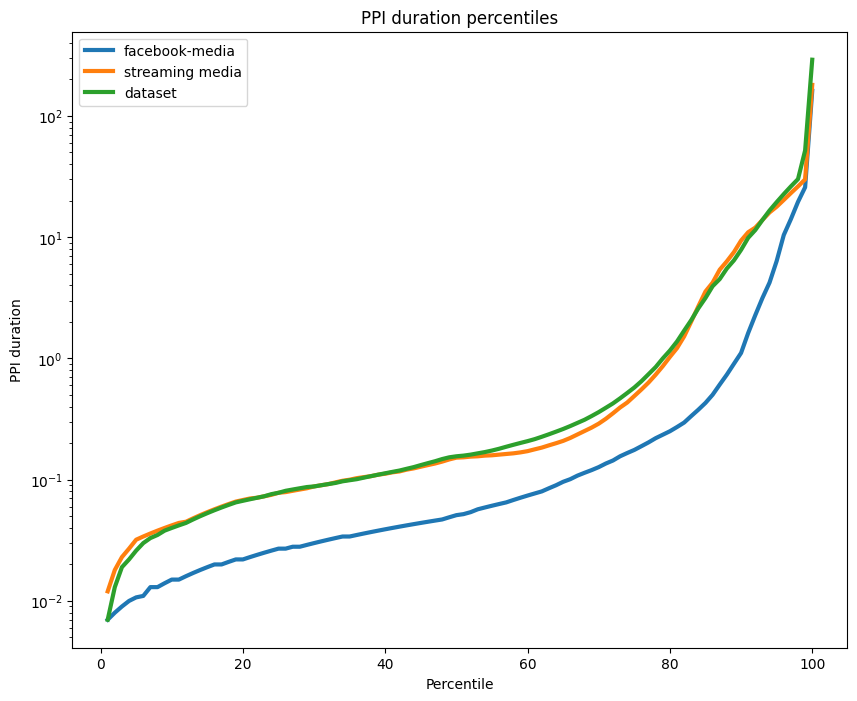

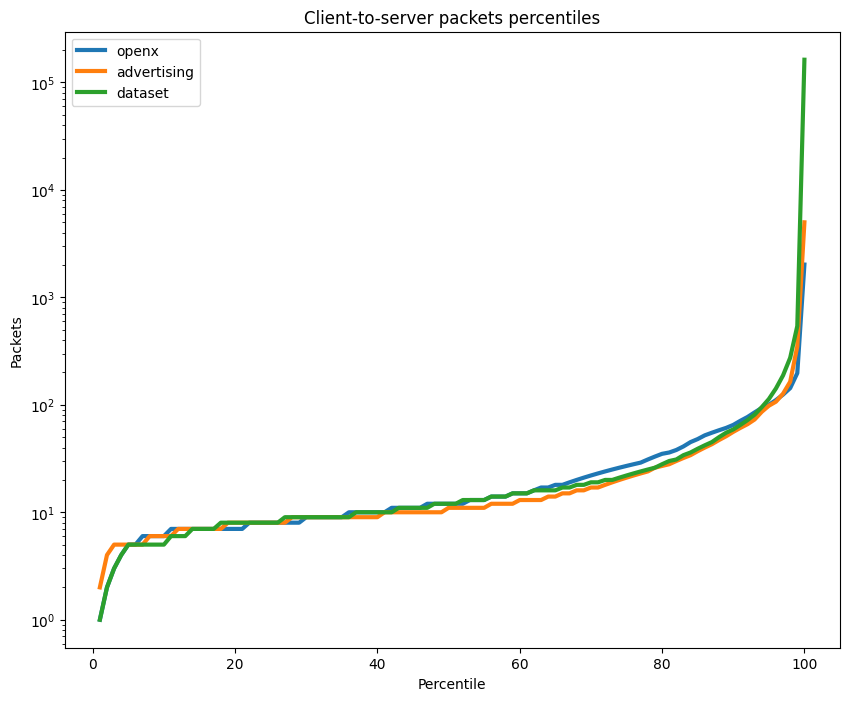

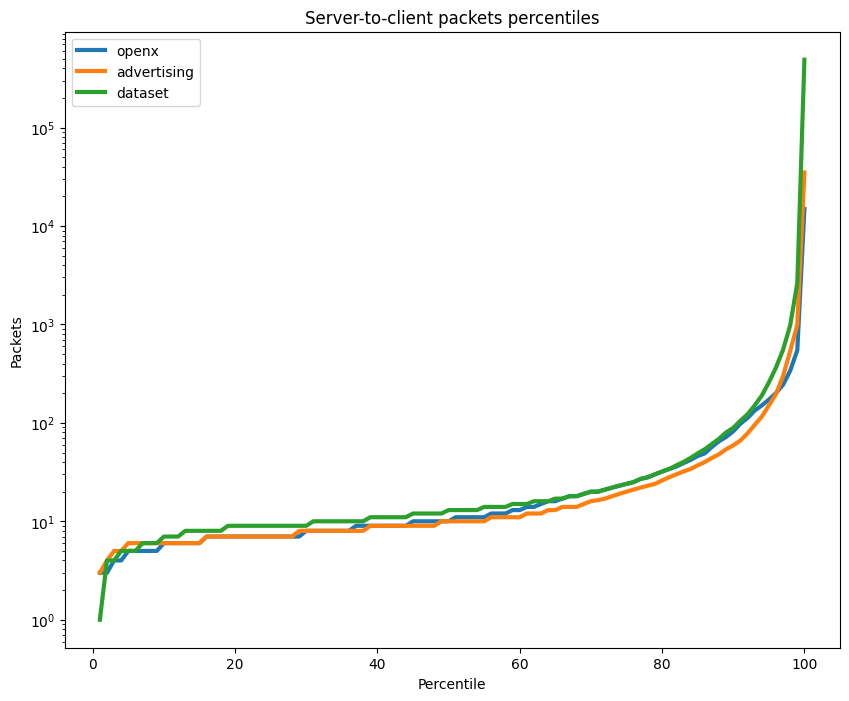

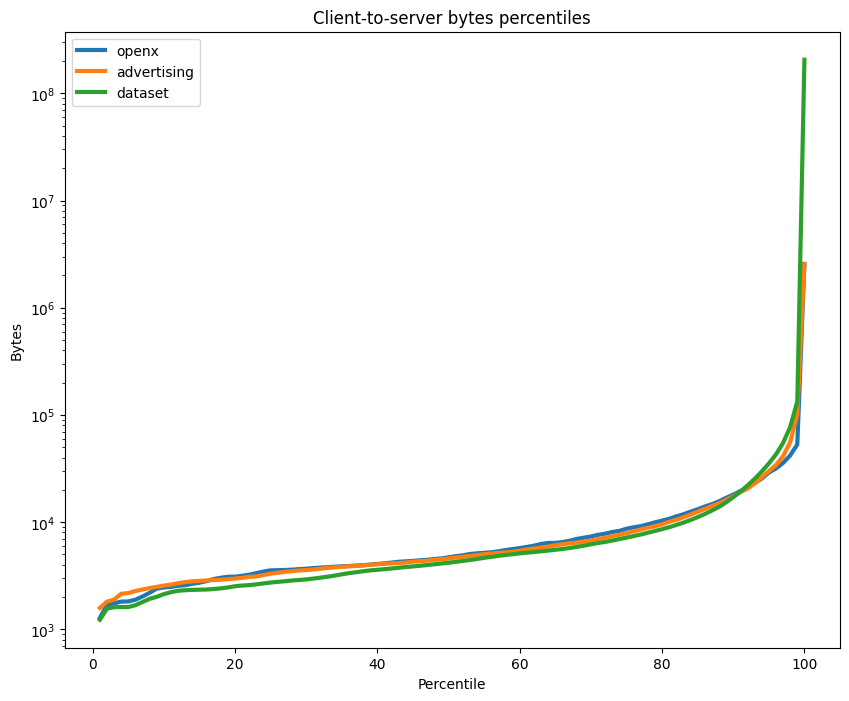

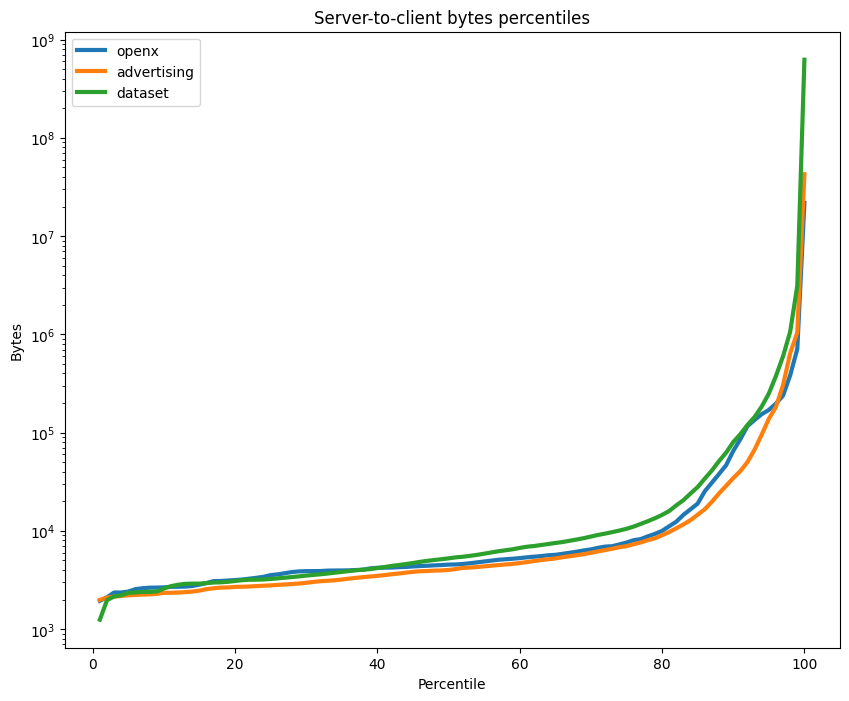

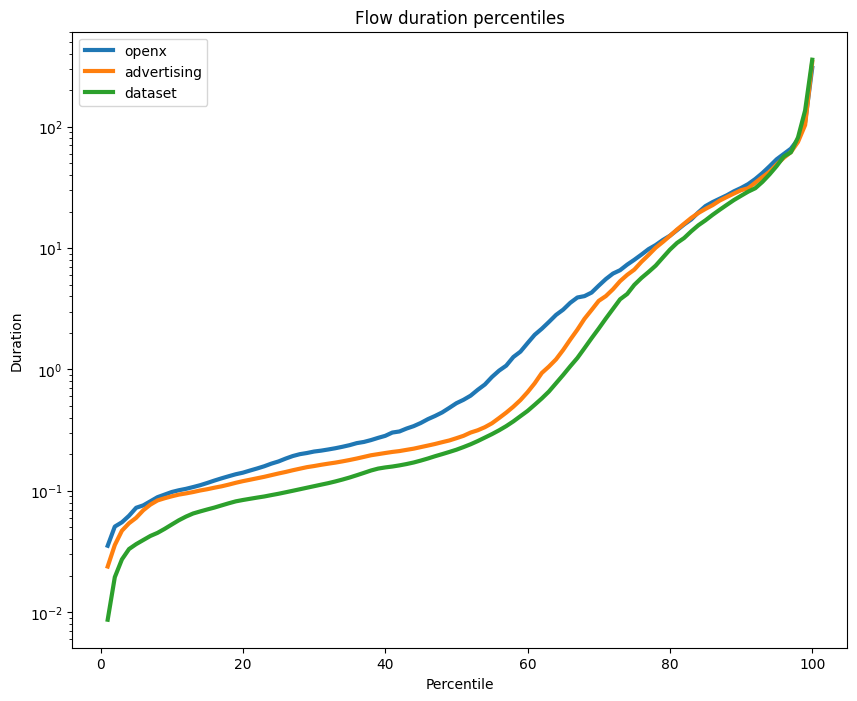

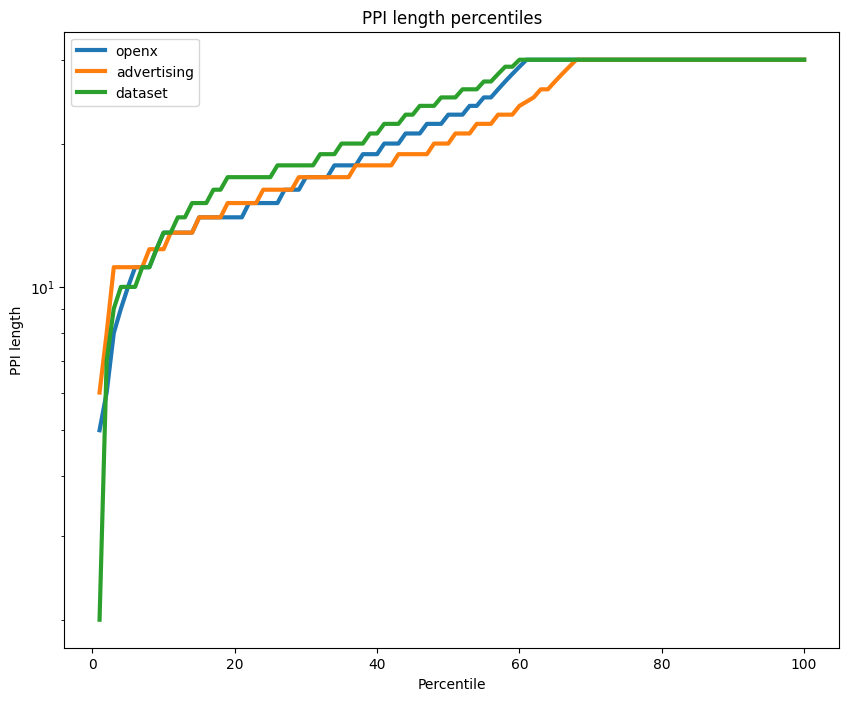

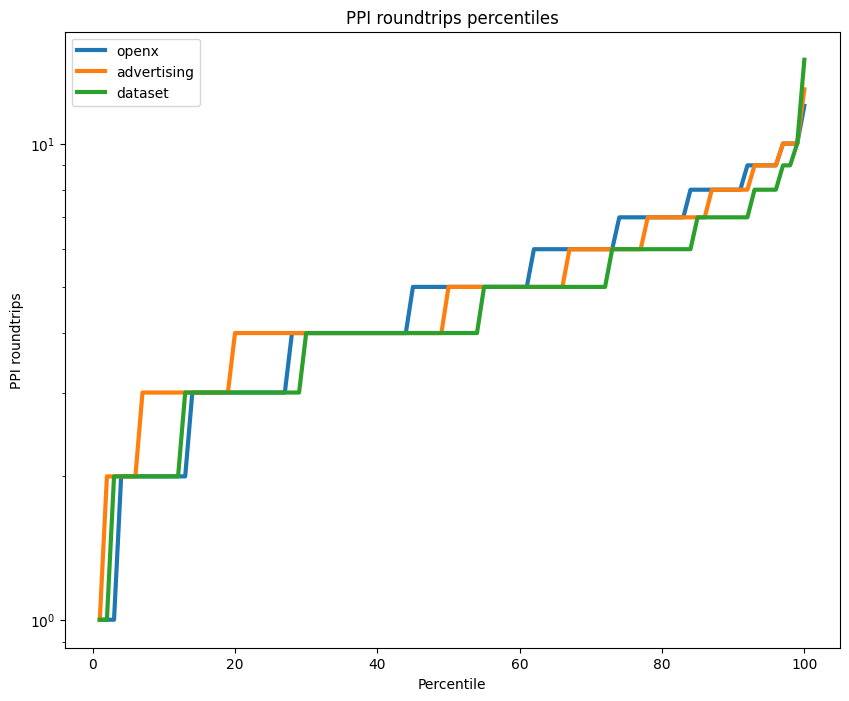

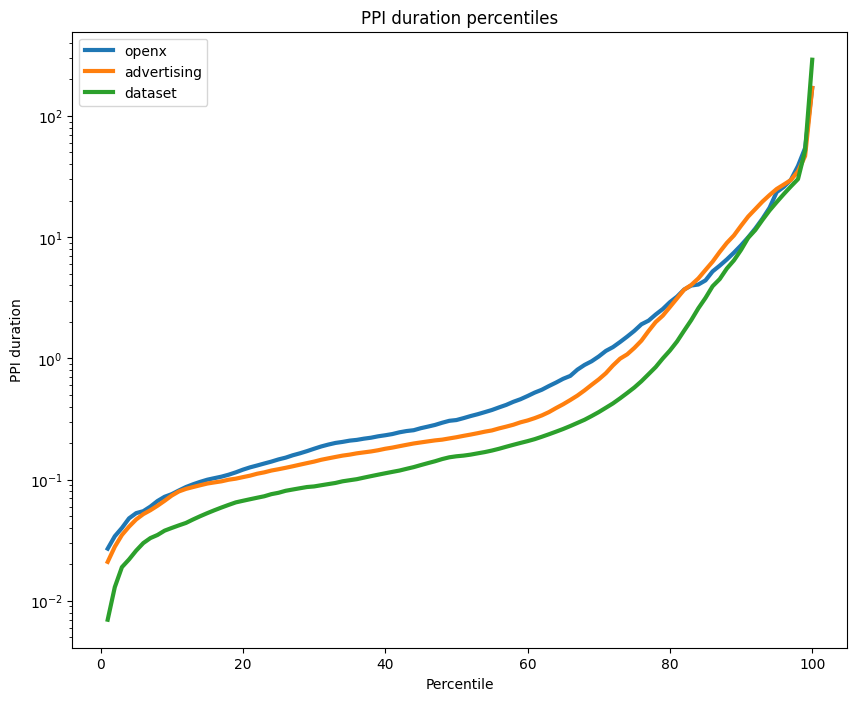

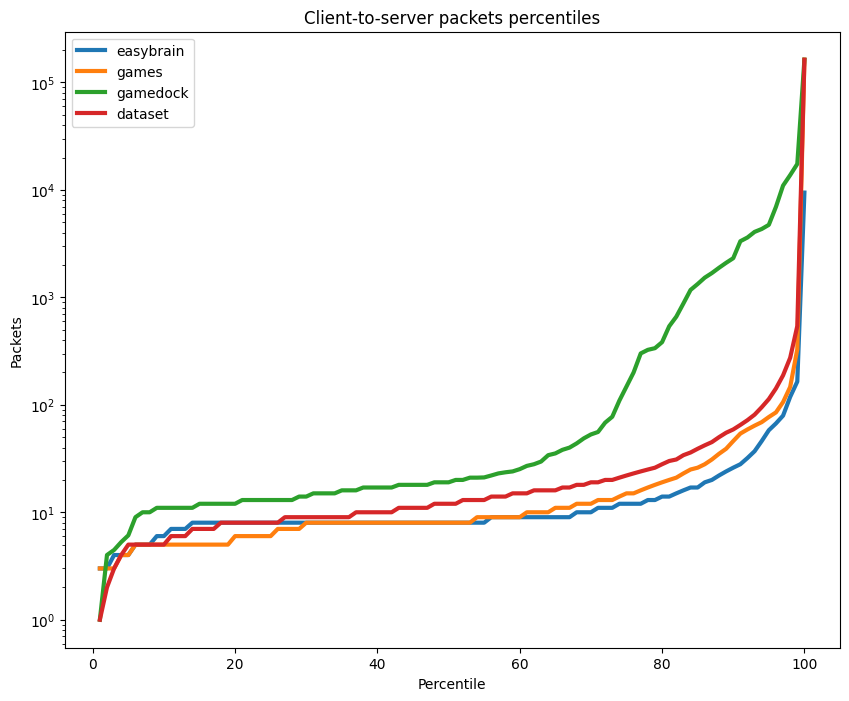

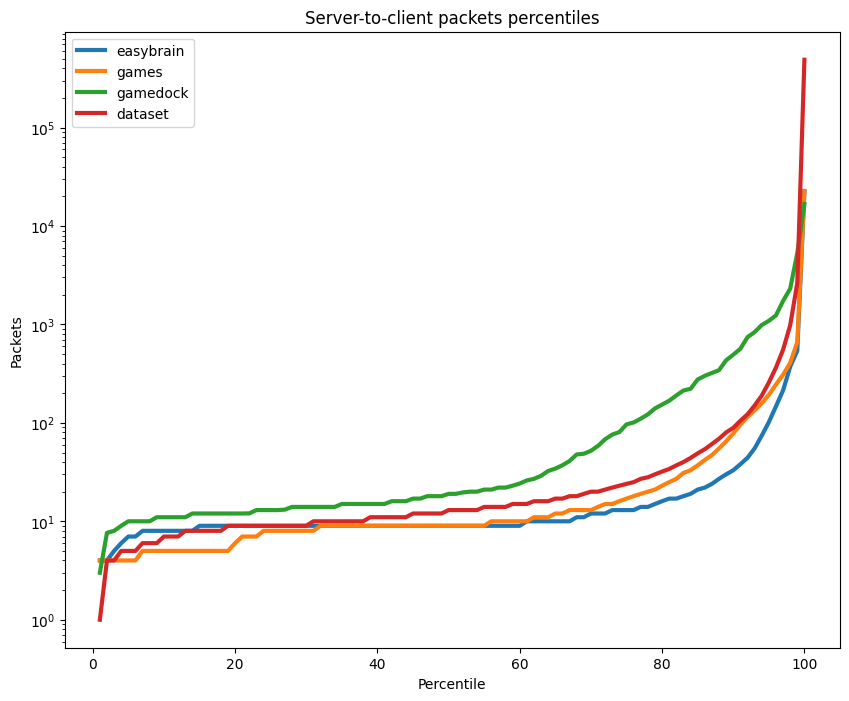

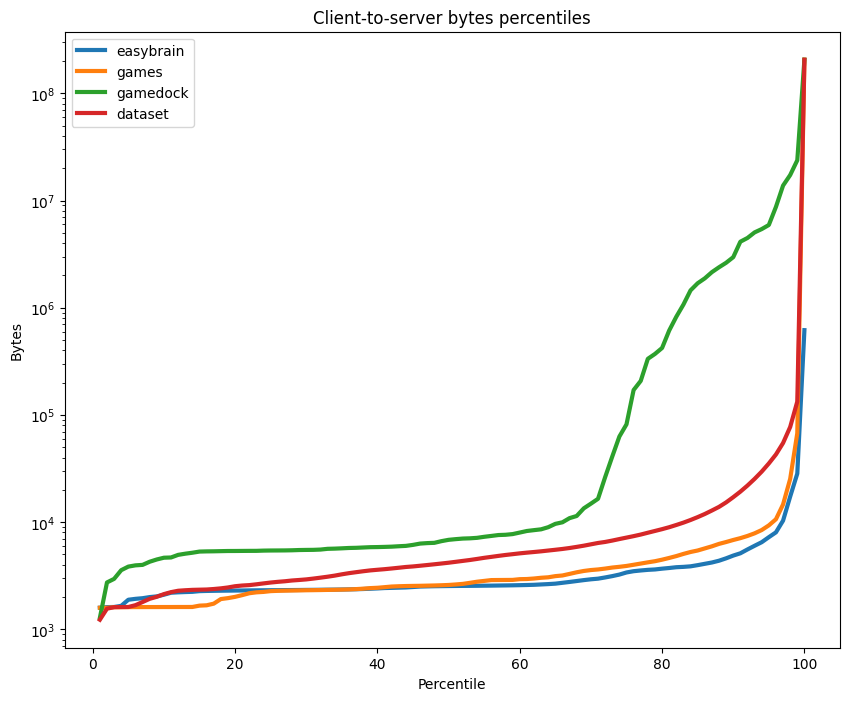

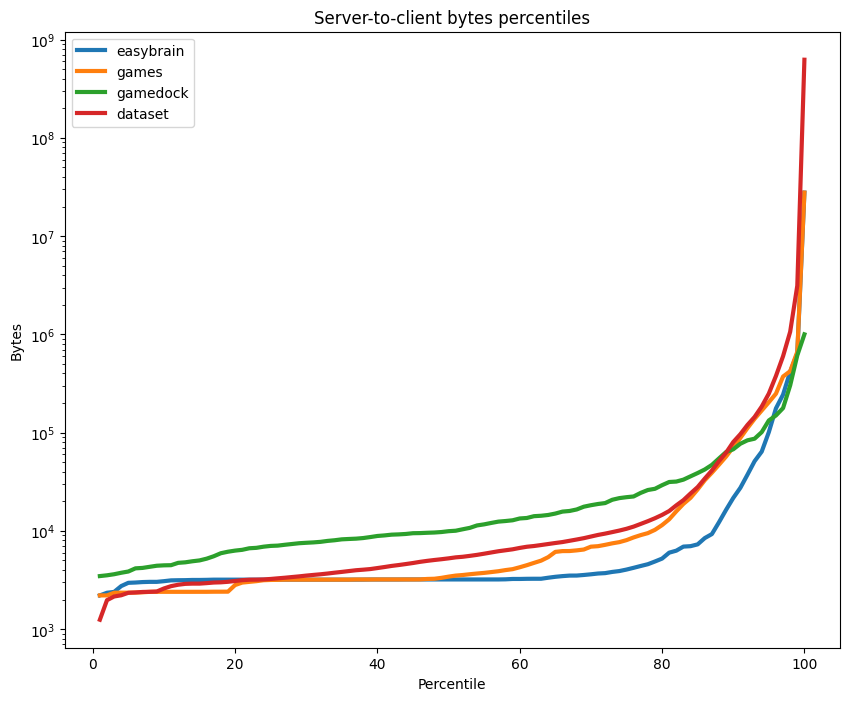

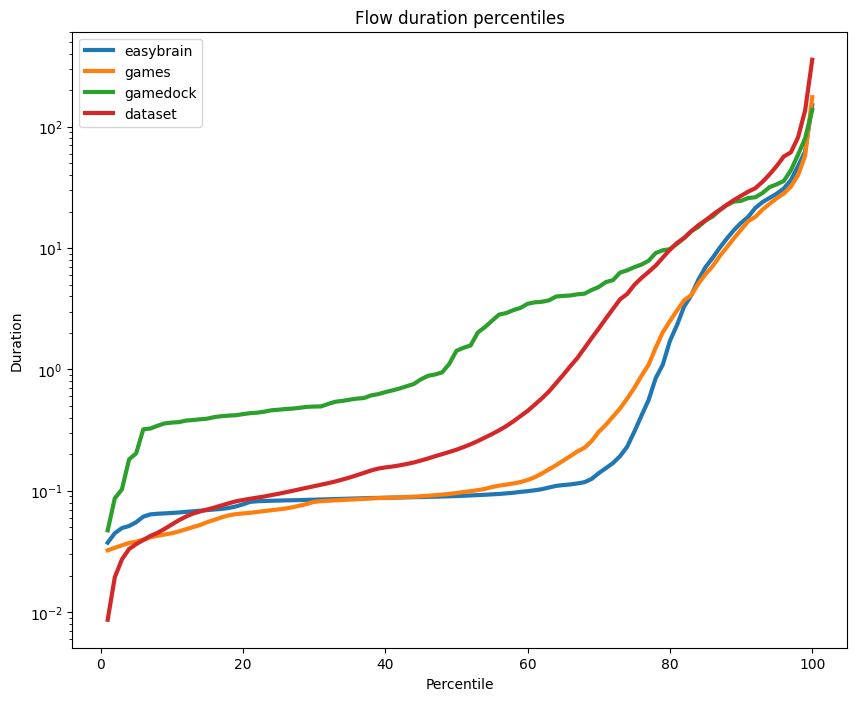

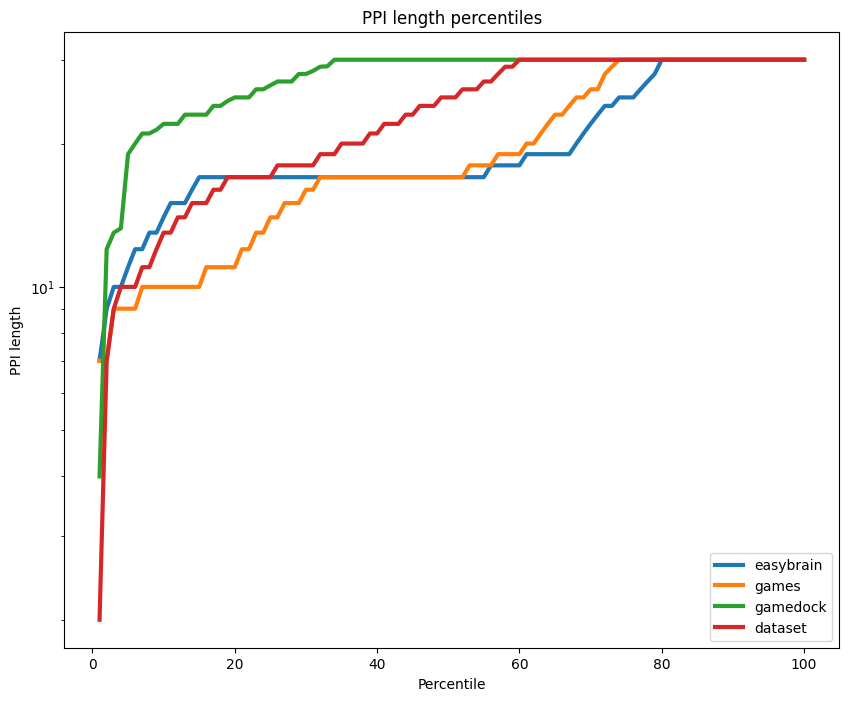

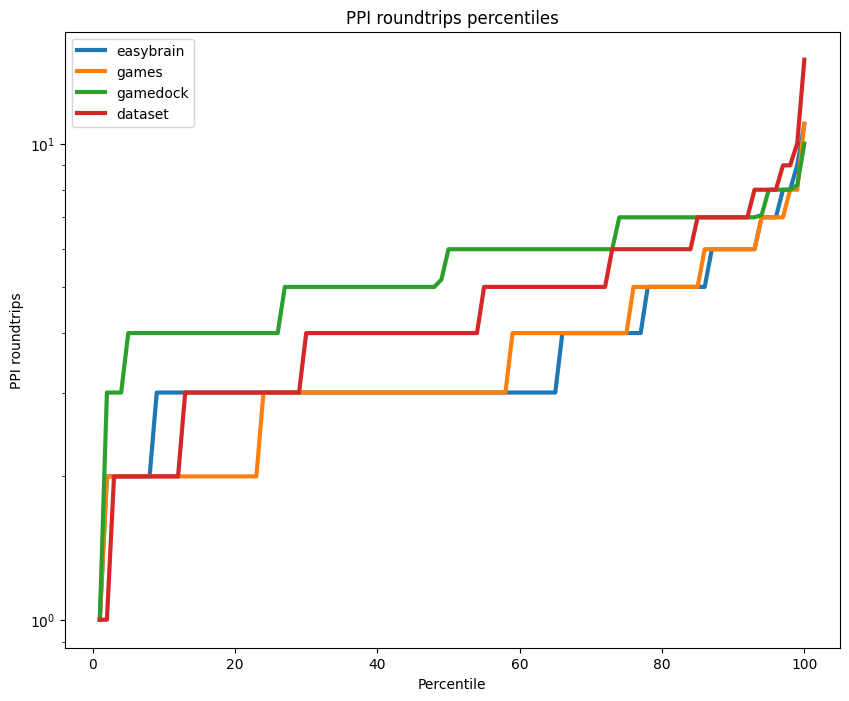

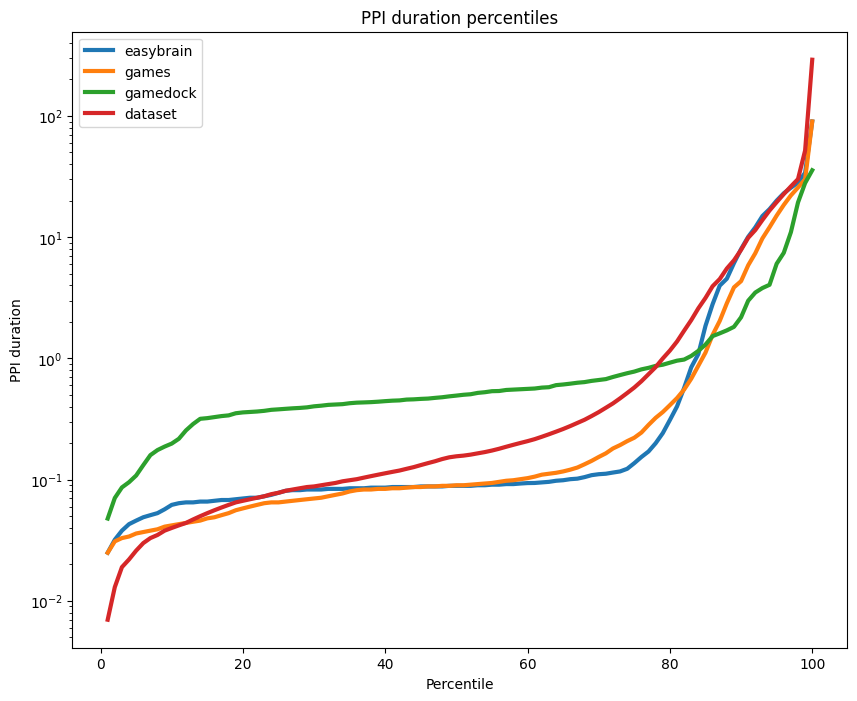

In [19]:
import numpy as np
import matplotlib.pyplot as plt

percentiles = range(1, 101)
apps_set = (
    ("apps", (("APP_NAME", "facebook-media"), ("APP_NAME", "openx"), ("APP_NAME", "easybrain"))),
    ("streamingmedia", (("APP_NAME", "facebook-media"), ("CATEGORY", "Streaming media"))),
    ("advertising", (("APP_NAME", "openx"), ("CATEGORY", "Advertising"))),
    ("games", (("APP_NAME", "easybrain"), ("CATEGORY", "Games"), ("APP_NAME", "gamedock")))
)

columns_explanation = (("Client-to-server packets percentiles", "Packets"),
                      ("Server-to-client packets percentiles", "Packets"),
                      ("Client-to-server bytes percentiles", "Bytes"),
                      ("Server-to-client bytes percentiles", "Bytes"),
                      ("Flow duration percentiles", "Duration"),
                      ("PPI length percentiles", "PPI length"),
                      ("PPI roundtrips percentiles", "PPI roundtrips"),
                      ("PPI duration percentiles", "PPI duration"))

for apps in apps_set:
    for column, column_explanation in zip(columns, columns_explanation):
        dataset_packets_percentiles = np.percentile(data_df[column], percentiles)

        # plot all three on the same graph, on log scale
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_yscale("log")
        for app in apps[1]:
            app_packets_percentiles = np.percentile(data_df[column][data_df[app[0]] == app[1]], percentiles)
            ax.plot(percentiles, app_packets_percentiles, label=app[1].lower(), linewidth=3)
        ax.plot(percentiles, dataset_packets_percentiles, label="dataset", linewidth=3)
        ax.set_title(column_explanation[0])
        ax.set_xlabel("Percentile")
        ax.set_ylabel(column_explanation[1])
        ax.legend()
        if ARE_PICTURES_SAVED: save_fig_to_images_dir(fig, f"{column}_{apps[0]}_comparison.pdf")

## Feature Engineering

Bytes per packet

In [20]:
data_df["BYTES_PER_PACKET"] = data_df["BYTES"] / data_df["PACKETS"]
data_df["BYTES_PER_PACKET_REV"] = data_df["BYTES_REV"] / data_df["PACKETS_REV"]

data_df[["APP_NAME", "BYTES_PER_PACKET", "BYTES_PER_PACKET_REV"]].groupby(by="APP_NAME").median()

,BYTES_PER_PACKET,BYTES_PER_PACKET_REV
APP_NAME,,
4chan,422.272736,641.900024
adavoid,317.970245,816.153870
alza-identity,309.875000,483.000000
alza-webapi,1228.000000,87.000000
alza-www,460.818176,495.750000
...,...,...
unpkg,272.323303,604.299194
vkontakte,478.714294,418.166656
whatsapp,418.875000,406.687500
